## Imports

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from sklearn.model_selection import train_test_split
from osgeo import gdal
from IPython.display import HTML
from base64 import b64encode
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from matplotlib import colors 

## Settings

In [2]:
dataset = '../input/land-use-land-cover-time-series/2019-10-01_2020-10-01.csv'

classe_info = {
  'not identified':           {'value':0, 'color': '#000000'},
  'soybean':                  {'value':1, 'color': '#ffe32e'},
  'maize':                    {'value':2, 'color': '#FF0000'},
  'cotton':                   {'value':3, 'color': '#0000FF'},
  'coffee':                   {'value':4, 'color': '#75781f'},
  'beans':                    {'value':5, 'color': '#e5eb34'},
  'wheat':                    {'value':6, 'color': '#ff24e5'},
  'sorghum':                  {'value':7, 'color': '#a80a96'},
  'millet':                   {'value':8, 'color': '#fa73eb'},
  'eucalyptus':               {'value':9, 'color': '#c75e0e'},
  'pasture':                  {'value':10, 'color': '#fff68f'},
  'hay':                      {'value':11, 'color': '#c9cf91'},
  'grass':                    {'value':12, 'color': '#12e362'},
  'crotalari':                {'value':13, 'color': '#12e362'},
  'maize+crotalari':          {'value':14, 'color': '#f77159'},
  'cerrado':                  {'value':15, 'color': '#5e2e10'},
  'conversion area':          {'value':16, 'color': '#12e0e3'},
  'uncultivated soil':        {'value':17, 'color': '#a9b0b0'},
  'ncc':                      {'value':18, 'color': '#12e362'},
  'brachiaria':               {'value':19, 'color': '#12e362'},
}

classes = {x : y.get('value') for x, y in classe_info.items()}

classe_colors = [y.get('color') for x, y in classe_info.items()]

n_features = 1

sequence_size = 30

model_dir = './logs'

## Load dataset

In [3]:
df = pd.read_csv(dataset)
df.head()

,date,evi,id,class
0,2019-10-16,0.152000,0,17
1,2019-11-01,0.148233,0,17
2,2019-11-17,0.155367,0,17
3,2019-12-03,0.173900,0,17
4,2019-12-19,0.228600,0,17


In [4]:
df['class_name'] = df.apply(lambda row: list(classes.keys())[list(classes.values()).index(row['class'])], axis = 1) 
df['date'] = pd.to_datetime(df['date'])
df.head()

,date,evi,id,class,class_name
0,2019-10-16,0.152000,0,17,uncultivated soil
1,2019-11-01,0.148233,0,17,uncultivated soil
2,2019-11-17,0.155367,0,17,uncultivated soil
3,2019-12-03,0.173900,0,17,uncultivated soil
4,2019-12-19,0.228600,0,17,uncultivated soil


## Plot time series

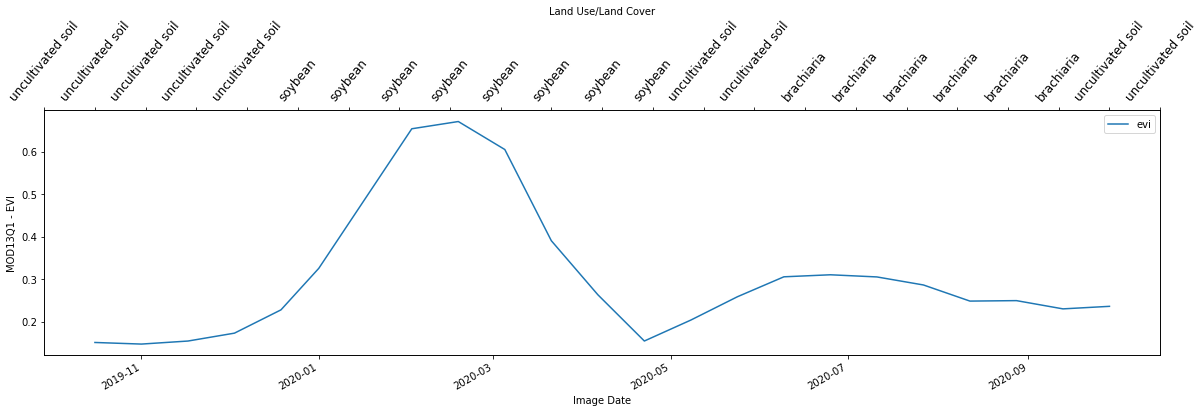

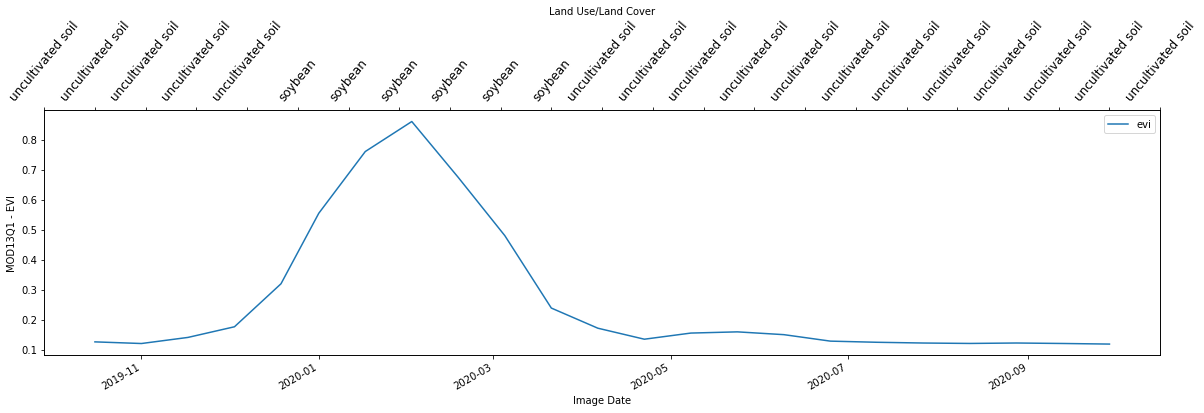

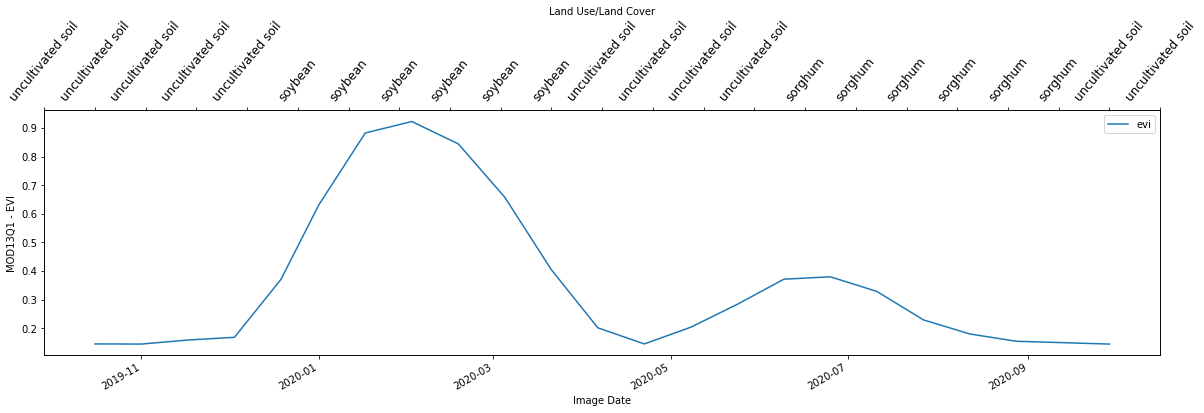

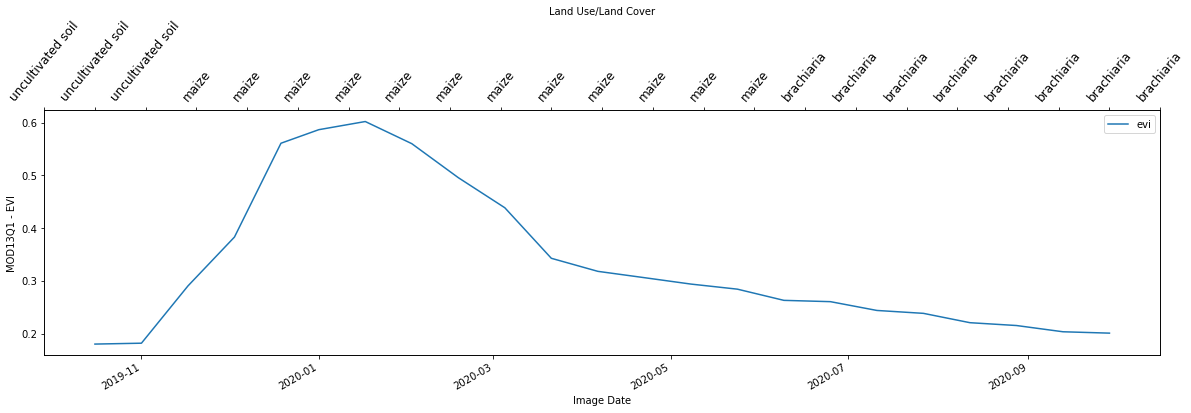

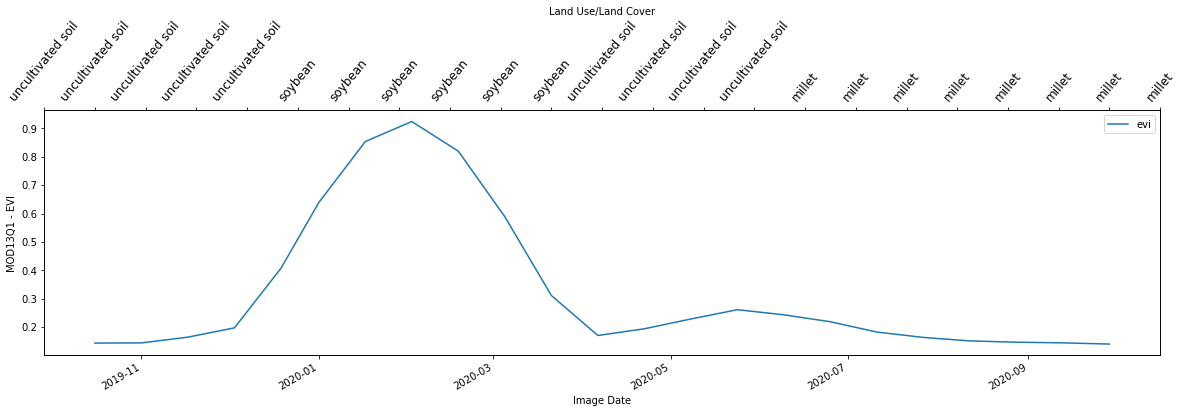

In [5]:
points = df.id.unique()

for point in points[:5]:
    point_df = df[df['id'] == point]
    point_df = point_df.sort_values(by=['date'])
    ax = point_df.plot(x='date', y='evi', figsize=(20, 5))

    axes1 = plt.gca()
    axes2 = axes1.twiny()
    
    class_names = point_df['class_name'].tolist()
    axes2.set_xticks(np.arange(len(class_names)))
    axes2.set_xticklabels(class_names, rotation=50, fontsize=12, minor=False)

    axes1.set_ylabel("MOD13Q1 - EVI")
    axes1.set_xlabel("Image Date")
    axes2.set_xlabel("Land Use/Land Cover")

## Prepare datasets

In [6]:
X = []
y = []

for point in points:
    point_df = df[df['id'] == point]
    point_df = point_df.sort_values(by=['date'])
    
    x_values = point_df['evi'].tolist()
    y_values = point_df['class'].tolist()

    x_values = tf.keras.preprocessing.sequence.pad_sequences([x_values], 
                                                             maxlen=sequence_size, dtype='float32')[0]
    y_values = tf.keras.preprocessing.sequence.pad_sequences([y_values], 
                                                             maxlen=sequence_size, 
                                                             value=classes.get('uncultivated soil'), dtype='float32')[0]
    
    X.append(x_values)
    
    labels = []
    for y_value in y_values:
        values = np.zeros(len(classes))
        np.put(values, [y_value], [1])
        labels.append(values)
        
    y.append(labels)
    
X = np.array(X)
y = np.array(y)

X = X.reshape((X.shape[0], X.shape[1], 1))

X.shape, y.shape

((10000, 30, 1), (10000, 30, 20))

## Split dataset in train, validation and test sets

In [7]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2)
X_validation, X_test, y_validation, y_test = train_test_split(X_validation, y_validation, test_size=0.5)

print("Train: ", len(X_train), "\nValidation: ", len(X_validation), "\nTest:", len(X_test))

Train:  8000 
Validation:  1000 
Test: 1000


In [8]:
X_train.shape, y_train.shape

((8000, 30, 1), (8000, 30, 20))

## Create LSTM model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200)               161600    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 200)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 200)           320800    
_________________________________________________________________
time_distributed (TimeDistri (None, 30, 100)           20100     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 30, 20)            2020      
_________________________________________________________________
activation (Activation)      (None, 30, 20)            0         
Total params: 504,520
Trainable params: 504,520
Non-trainable params: 0
__________________________________________________

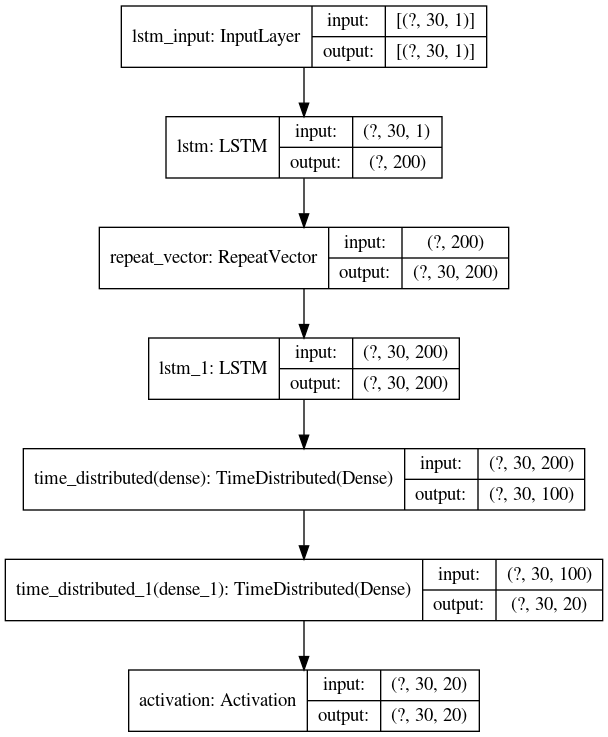

In [9]:
def LSTM(n_classes, sequence_size, n_features):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.LSTM(200, input_shape=(sequence_size, n_features)))
    
    model.add(tf.keras.layers.RepeatVector(sequence_size))
    
    model.add(tf.keras.layers.LSTM(200, activation='relu', return_sequences=True))
    
    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(100, activation='relu')))

    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_classes)))
    
    model.add(tf.keras.layers.Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model
              
model = LSTM(n_classes=len(classes), sequence_size=sequence_size, n_features=n_features)
              
model.summary()

tf.keras.utils.plot_model(model, show_shapes=True, to_file='/kaggle/working/model.png')

## Create callbacks

In [10]:
checkpoint_path = "{dir}/model.ckpt".format(dir=model_dir)

latest = tf.train.latest_checkpoint(model_dir)

if latest:
    model.load_weights(latest)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, save_best_only=True)

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto', 
                                            baseline=None, restore_best_weights=True)

callbacks = [cp_callback, es_callback]

## Train model

In [11]:
epochs = 500
batch_size = 128

history = model.fit(x=X_train, y=y_train, 
          validation_data=(X_validation, y_validation),
          epochs=epochs, batch_size=batch_size, callbacks=callbacks, use_multiprocessing=False, verbose=1)

Epoch 1/500
63/63 [==============================] - 4s 63ms/step - loss: 1.9271 - accuracy: 0.5866 - val_loss: 1.1700 - val_accuracy: 0.6511
Epoch 2/500
63/63 [==============================] - 3s 55ms/step - loss: 1.1531 - accuracy: 0.6577 - val_loss: 1.0932 - val_accuracy: 0.6688
Epoch 3/500
63/63 [==============================] - 4s 70ms/step - loss: 1.1274 - accuracy: 0.6558 - val_loss: 1.1806 - val_accuracy: 0.6489
Epoch 4/500
63/63 [==============================] - 4s 57ms/step - loss: 1.1009 - accuracy: 0.6619 - val_loss: 1.0665 - val_accuracy: 0.6637
Epoch 5/500
63/63 [==============================] - 4s 64ms/step - loss: 1.0715 - accuracy: 0.6573 - val_loss: 1.0974 - val_accuracy: 0.6635
Epoch 6/500
63/63 [==============================] - 5s 74ms/step - loss: 1.0089 - accuracy: 0.6783 - val_loss: 0.8925 - val_accuracy: 0.7049
Epoch 7/500
63/63 [==============================] - 4s 64ms/step - loss: 0.8800 - accuracy: 0.7111 - val_loss: 0.7749 - val_accuracy: 0.7557
Epoch 

## Plot training and validation loss

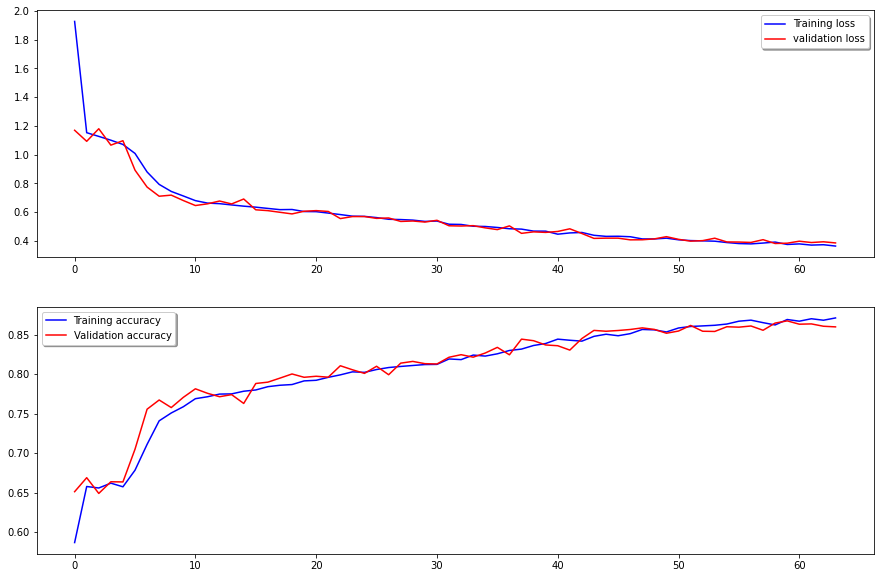

In [12]:
fig, ax = plt.subplots(2,1, figsize=(15, 10))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

## Load best model

In [13]:
latest = tf.train.latest_checkpoint(model_dir)
model.load_weights(latest)

## Evaluate model

In [14]:
model.evaluate(X_test, y_test, batch_size=128)

8/8 [==============================] - 0s 7ms/step - loss: 0.3771 - accuracy: 0.8691


[0.3771166503429413, 0.8690999746322632]

## Predict image

In [15]:
image_path = '../input/land-use-land-cover-time-series/2019-10-01_2020-10-01.tif'
predicted_path = './2019-10-01_2020-10-01_predicted.tif'
data_source = gdal.Open(image_path)
image = data_source.ReadAsArray()
image.shape

(23, 1401, 816)

In [16]:
flat_image = image.reshape(image.shape[0],
                           image.shape[1] * image.shape[2])

flat_image = flat_image.transpose()

flat_image = flat_image.reshape((flat_image.shape[0],
                                 flat_image.shape[1],
                                 n_features))

flat_image = np.array(flat_image).astype(float)

flat_image.shape

(1143216, 23, 1)

In [17]:
flat_image = tf.keras.preprocessing.sequence.pad_sequences(flat_image, maxlen=sequence_size, dtype='float32')

flat_image.shape

(1143216, 30, 1)

In [18]:
flat_predicted = model.predict(flat_image, batch_size=1024)
flat_predicted.shape

(1143216, 30, 20)

In [19]:
flat_labels = np.argmax(flat_predicted, axis=2)
flat_predicted.shape, '-->', flat_labels.shape

((1143216, 30, 20), '-->', (1143216, 30))

In [20]:
predicted_image = flat_labels.reshape((image.shape[1], image.shape[2], flat_labels.shape[-1]))
predicted_image.shape

(1401, 816, 30)

In [21]:
predicted_image = predicted_image[:, :, predicted_image.shape[-1] - image.shape[0]:]
predicted_image.shape

(1401, 816, 23)

In [22]:
# save results
driver = data_source.GetDriver()
output_dataset = driver.Create(predicted_path,
                               predicted_image.shape[1],
                               predicted_image.shape[0],
                               predicted_image.shape[-1],
                               gdal.GDT_Byte,
                               ['COMPRESS=DEFLATE'])
output_dataset.SetGeoTransform(data_source.GetGeoTransform())
output_dataset.SetProjection(data_source.GetProjection())

for band_id in range(predicted_image.shape[-1]):
    band_data = predicted_image[:, : , band_id]        
    output_dataset.GetRasterBand(band_id + 1).WriteArray(band_data, 0, 0)
output_dataset.FlushCache()
del output_dataset
print("Completed!")

Completed!


## Load predicted image

In [23]:
data_source = gdal.Open(predicted_path)
image = data_source.ReadAsArray()
image.shape

(23, 1401, 816)

## Plot predicted image

In [24]:
def play(filename):
    html = ''
    video = open(filename,'rb').read()
    src = 'data:video/mp4;base64,' + b64encode(video).decode()
    html += '<video width=1000 controls autoplay loop><source src="%s" type="video/mp4"></video>' % src 
    return HTML(html)

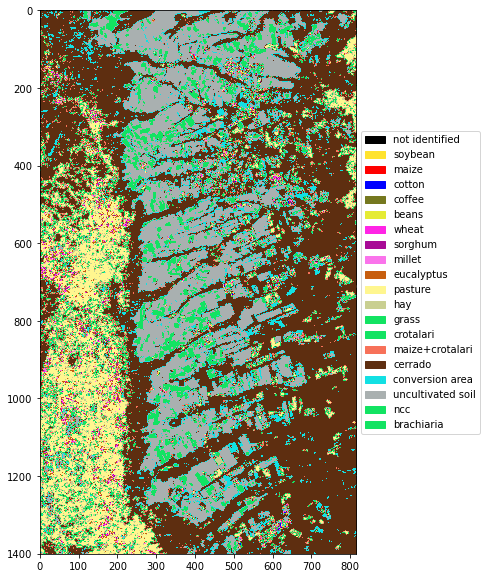

In [25]:
fig, ax = plt.subplots(figsize=(15, 10))

ims = []

cmap = colors.ListedColormap(classe_colors) 

for band in image:
    im = ax.imshow(band, vmin=0, vmax=len(classe_colors)-1, cmap=cmap, animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=1000, blit=True, repeat_delay=1000)

patches = list(map(lambda item: mpatches.Patch(color=item[1].get('color'), label=item[0]), classe_info.items() ))
plt.legend(handles=patches, loc='center left', bbox_to_anchor=(1, 0.5))
    

output = '/kaggle/working/predicted.mp4'

ani.save(output)

play(output)